In [125]:
import cv2
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

In [74]:
dataset_path = Path('icg-freshers-data-science-competition/Dataset/')
train_path = dataset_path/"Train"
test_path = dataset_path/"Test"

In [75]:
train_path

PosixPath('icg-freshers-data-science-competition/Dataset/Train')

In [76]:
# count
for x, y, z in os.walk('icg-freshers-data-science-competition/Dataset/'):
    print(x,y,z)

icg-freshers-data-science-competition/Dataset/ ['Train', 'Test'] ['Sample_submission.csv']
icg-freshers-data-science-competition/Dataset/Train ['Zeroes_and_Crosses', 'Grids'] ['.~lock.Grid_labels.csv#', 'Grid_labels.csv']
icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses ['Zeroes', 'Cross'] []
icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes [] ['594.png', '611.png', '607.png', '597.png', '614.png', '599.png', '596.png', '601.png', '618.png', '609.png', '602.png', '617.png', '616.png', '604.png', '598.png', '613.png', '605.png', '595.png', '612.png', '610.png', '600.png', '615.png', '603.png', '606.png', '608.png']
icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Cross [] ['188.png', '195.png', '201.png', '185.png', '183.png', '184.png', '200.png', '194.png', '197.png', '191.png', '203.png', '189.png', '187.png', '205.png', '196.png', '204.png', '193.png', '202.png', '192.png', '186.png', '199.png', '190.png', '182

In [77]:
Path.cwd()

PosixPath('/home/aarush/Aarush/Coding/ICG Project')

In [78]:
train_images = list(train_path.glob("*/*/*.png"))
test_images = list(test_path.glob("*.png"))
train_images

[PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/594.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/611.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/607.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/597.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/614.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/599.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/596.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/601.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/618.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/6

In [80]:
len(train_images),len(test_images)

(50, 4495)

In [81]:
img = Image.open(train_images[2])

In [82]:
np.asarray(img).shape

(28, 28)

In [65]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [95]:
train_data = datasets.ImageFolder(root=Path.joinpath(train_path,"Zeroes_and_Crosses"), # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

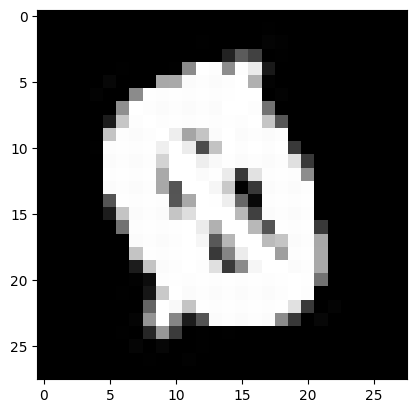

In [96]:

img = train_data[3][0]
img_permute = img.permute(1, 2, 0)
plt.imshow(img_permute)

In [86]:
train_data.classes

['Cross', 'Zeroes']

In [120]:
len(train_data)

50

In [129]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=5, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?


In [124]:
next(iter(train_dataloader))[0].shape

torch.Size([1, 3, 28, 28])

In [126]:
flatten_model = nn.Flatten()

In [133]:
# Create a convolutional neural network 
class Model_for_checking_0orX(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# optio784*100*100*10*60000/32ns = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model = Model_for_checking_0orX(input_shape=3, 
    hidden_units=20, 
    output_shape=len(train_data.classes))
model

Model_for_checking_0orX(
  (block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=980, out_features=2, bias=True)
  )
)

In [142]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), 
                             lr=0.1)

In [147]:
def accuracy_function(y_pred,y):
    return torch.eq(y_pred.argmax(1),y).sum().item()/len(y_pred)*100

In [151]:
train_loss, train_acc = 0, 0
epochs = 3
for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    for Batch,(X,y) in enumerate(iter(train_dataloader)):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss +=loss
        accuracy = accuracy_function(y_pred,y) 
        train_accuracy+=accuracy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if Batch%300 == 0 :
            print(f"Batch Number:{Batch}|Loss:{loss}|Accuracy:{accuracy}")
    print(f"\nAverage loss: {(train_loss/len(train_dataloader))}|Average Accuracy:{(train_accuracy/len(train_dataloader))}%\n")

Batch Number:0|Loss:4.2745614337036386e-05|Accuracy:100.0

Average loss: 3.188037590007298e-05|Average Accuracy:100.0%

Batch Number:0|Loss:2.908686383307213e-06|Accuracy:100.0

Average loss: 1.897958281915635e-05|Average Accuracy:100.0%

Batch Number:0|Loss:1.3088787454762496e-05|Accuracy:100.0

Average loss: 2.4585315259173512e-05|Average Accuracy:100.0%



In [156]:
img,
y_pred = model(train_data[:,0].unsqueeze(0))

TypeError: list indices must be integers or slices, not tuple

In [160]:
train_images

[PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/594.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/611.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/607.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/597.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/614.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/599.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/596.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/601.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/618.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/6

In [174]:
y_pred = []
for x in range(len(train_data)):
    result = model(train_data[x][0].unsqueeze(0)).argmax(1)
    y_pred.append(result)

In [175]:
y_pred

[tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1])]

In [188]:
class_names = train_data.classes
def is_equal(y_pred,y):
    if y_pred == y:
        return 1
    else:
        return 0

(-0.5, 27.5, 27.5, -0.5)

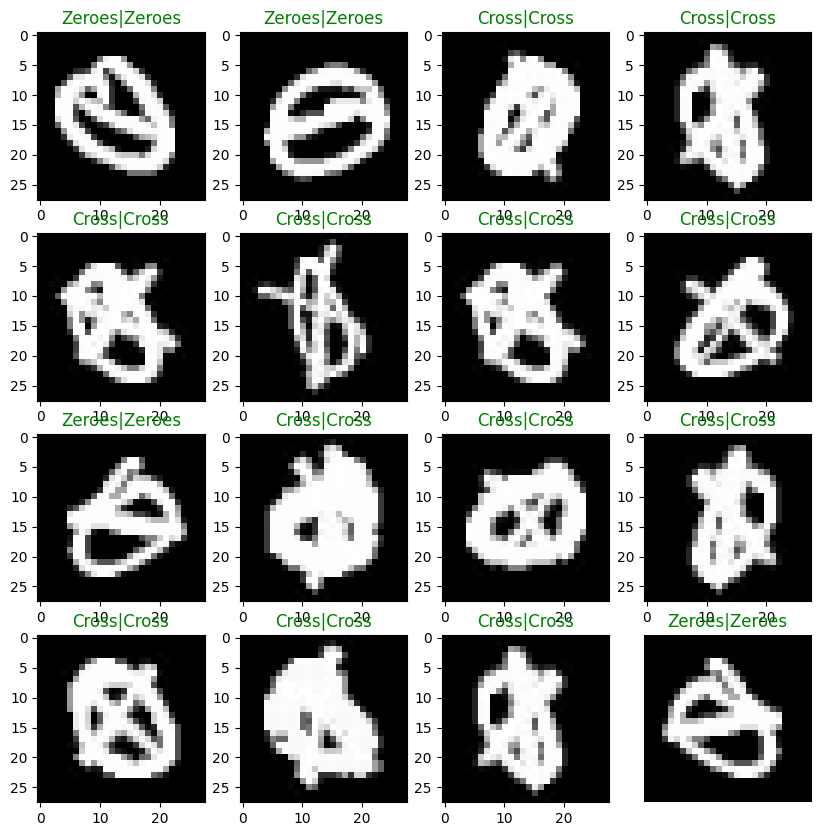

In [189]:
No_of_values_to_predict = 16
plt.figure(figsize=(10,10))
Color = ['r','g']
list_indices = np.random.randint(0,len(train_data),16)
for x in range(16):
    plt.subplot(4,4,x+1)
    plt.imshow(train_data[list_indices[x]][0].squeeze().permute(1,2,0),cmap='gray')
    plt.title(f"{train_data.classes[y_pred[list_indices[x]]]}|{class_names[train_data[list_indices[x]][1]]}",c=Color[is_equal(y_pred[list_indices[x]],train_data.targets[list_indices[x]])])
plt.axis(False)